In [1]:
!pip install timm

     |████████████████████████████████| 431 kB 921 kB/s            


Elena Lisitsyna

In [2]:
import numpy as np
import pandas as pd
import copy
import os
import random
from tqdm import tqdm
from textwrap import wrap

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm # timm can create/load in models that are in the library

In [3]:
f = open('../input/ip102-v8/Data/newClasses.txt')
label = []
name = []
for line in f.readlines():
    label.append(int(line.split()[0]))
    name.append(' '.join(line.split()[1:]))
classes = pd.DataFrame([label, name]).T
classes.columns = ['label','name']
classes

,label,name
0,1,black cutworm
1,2,yellow cutworm
2,3,corn borer
3,4,army worm


In [4]:
train_df = pd.read_csv('../input/ip102-v8/Data/train.txt',sep=' ',header=None, engine='python')
train_df.columns = ['image_path','label']

test_df = pd.read_csv('../input/ip102-v8/Data/test.txt',sep=' ',header=None, engine='python')
test_df.columns = ['image_path','label']

val_df = pd.read_csv('../input/ip102-v8/Data/val.txt',sep=' ',header=None, engine='python')
val_df.columns = ['image_path','label']

train_df.head()

,image_path,label
0,11961.jpg,0
1,11971.jpg,0
2,11980.jpg,0
3,11990.jpg,0
4,11992.jpg,0


In [5]:
TRAIN_DIR = '../input/ip102-v8/Data/classification/train'
TEST_DIR = '../input/ip102-v8/Data/classification/test'
VAL_DIR = '../input/ip102-v8/Data/classification/val'
LR = 1e-5 # learning rate
BATCH_SIZE = 8 # number of training examples per pass
EPOCH = 100 # each epoch is a pass of all training examples

torch.cuda.is_available()
device = torch.device('cuda') #using GPU

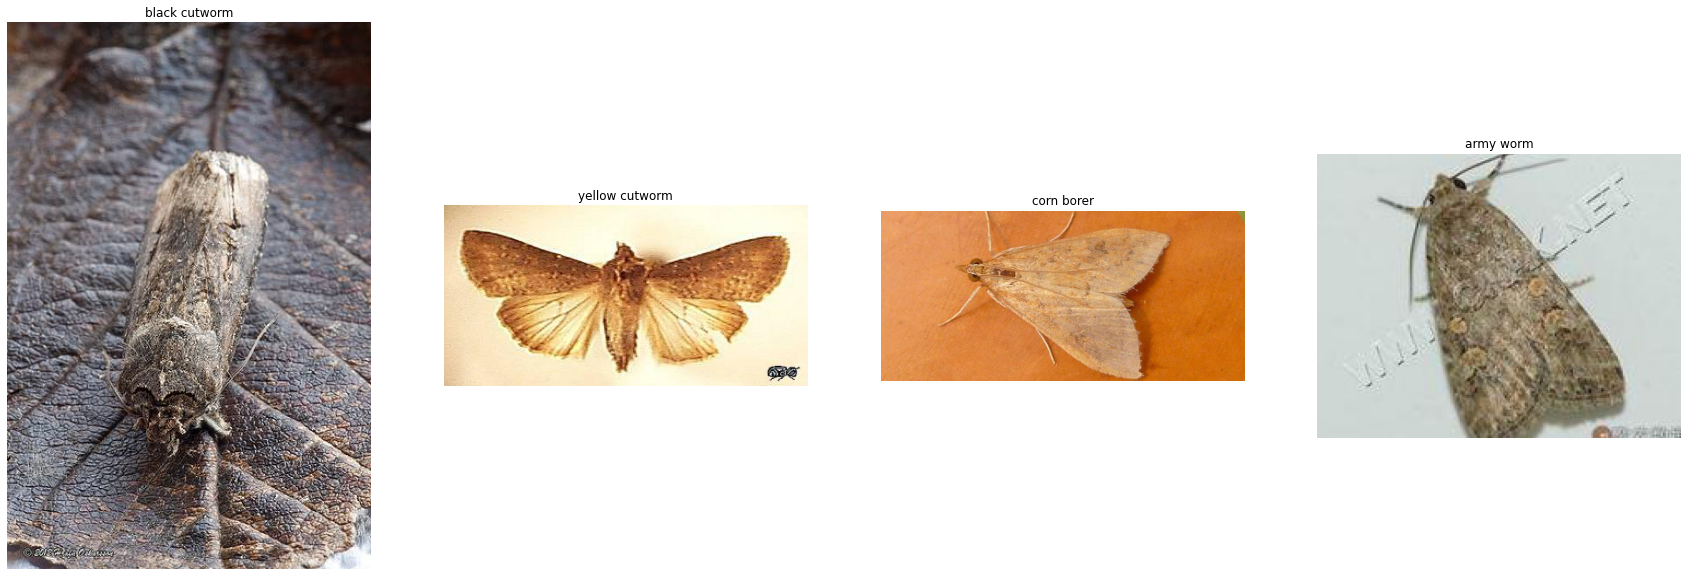

In [6]:
fig, axs = plt.subplots(1,4,figsize=(30,30)) # upping sizing a bit to better inspect
images = []
for i in classes.label:
    random_img = random.choice(train_df[train_df.label==i-1].image_path.values) # choose images randomly
    label = classes.name[i-1] # label images
    img = plt.imread(os.path.join(TRAIN_DIR,str(i-1),random_img))
    images.append(img)

[ax.imshow(image) for image,ax in zip(images,axs.ravel())]
[ax.set_title("\n".join(wrap(label,20))) for label,ax in zip(list(classes.name),axs.ravel())]
[ax.set_axis_off() for ax in axs.ravel()]
plt.show() # show plot

In [7]:
class InsectModel(nn.Module):
    def __init__(self,num_classes, transform = None):
        super(InsectModel, self).__init__()
        self.num_classes = num_classes
        self.model = timm.create_model('vit_base_patch16_224',pretrained=True,num_classes=num_classes)
        self.transform = transform
    def forward(self, image):
        return self.model(image)

In [8]:
class InsectDataset(Dataset):
    def __init__(self, image, image_dir, transform=None):
        self.image_info = image
        self.transform = transform
        self.imgdir = image_dir
    def __len__(self):
        return self.image_info.shape[0]
    def __getitem__(self, index):
        image_info = self.image_info[index]
        image = cv2.imread(os.path.join(self.imgdir,str(image_info[1]),image_info[0]),cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.
        
        if self.transform is not None:
            image = self.transform(image = image)['image']
        
        label = image_info[1]
        
        image = torch.as_tensor(image, dtype=torch.float32)
        label = torch.as_tensor(label, dtype=torch.long)
        return image, label

In [9]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [10]:
def train_transform(): # transforming the images of train set
    return A.Compose([
        A.Resize(264, 264),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=224, width=224),
        A.HorizontalFlip(),
        A.RGBShift(r_shift_limit=0.05, g_shift_limit=0.05, b_shift_limit=0.05, p=0.25),
        #A.RandomRotate90(),
        A.ColorJitter (brightness=0.1, contrast=0.1, saturation=0.3, hue=0, always_apply=False, p=0.5), 
        A.ToGray(p=0.15),
        #A.ToSepia(p=0.05),
        ToTensorV2()])

def valid_transform():
    return A.Compose([
        A.Resize(224,224), #resize only
        #A.Resize(264,264), #resize
        #A.CenterCrop(height=224, width=224), #center crop to match the size 224x224
        ToTensorV2()])

def test_transform(): 
    return A.Compose([
        A.Resize(224,224),
        ToTensorV2()])

def visualize_augmentations(dataset, idx=5, samples=10, cols=5): #show augmentations applied to train data, idx - img#
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

In [11]:
train_dataset = InsectDataset(image=train_df.values, 
                              image_dir=TRAIN_DIR, 
                              transform=train_transform())
train_data_loader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=2)
val_dataset = InsectDataset(image=val_df.values,
                            image_dir=VAL_DIR,
                            transform=valid_transform())
val_data_loader = DataLoader(val_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=2)


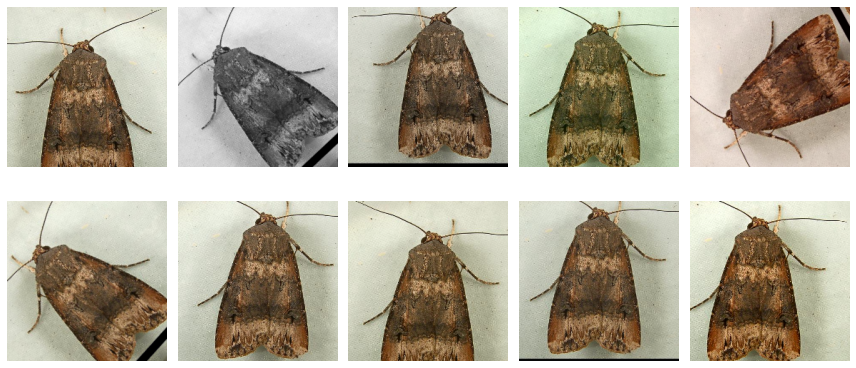

In [12]:
random.seed(12)
visualize_augmentations(train_dataset)

In [13]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.loss = 0
        self.correct = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, loss,correct, n=1):
        self.loss = loss
        self.correct += correct
        self.sum += loss * n
        self.count += n
        
        self.avg = self.sum / self.count
        self.acc = self.correct / self.count
        
class Accuracy(object):
    def __init__(self):
        self.reset

In [14]:
def train_fn(data_loader, model, criterion, device, optimizer, epoch):
    model.train()
    criterion.train()
    
    summary = AverageMeter()
    tk0 = tqdm(data_loader, total=len(data_loader))
    for step, (images, labels) in enumerate(tk0):
        images = images.to(device, non_blocking = True).float()
        labels = labels.to(device, non_blocking = True).long()
    
        output = model(images)
        loss = criterion(output, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        preds = output.softmax(1).argmax(1)
        correct = (preds == labels).sum().item()
        
        summary.update(loss.item(),correct, BATCH_SIZE)
        tk0.set_postfix(loss=summary.avg, acc=summary.acc, epoch=epoch+1)
    return summary

def eval_fn(data_loader, model, criterion, device, epoch):
    model.eval()
    criterion.eval()
    
    summary = AverageMeter()
    tk0 = tqdm(data_loader, total=len(data_loader))
    with torch.no_grad():
        for step, (images, labels) in enumerate(tk0):
            images = images.to(device, non_blocking = True).float()
            labels = labels.to(device, non_blocking = True).long()
            
            output = model(images)
            loss = criterion(output, labels)
            
            preds = output.softmax(1).argmax(1)
            correct = (preds == labels).sum().item()
            
            summary.update(loss.item(), correct, BATCH_SIZE)
            tk0.set_postfix(loss=summary.avg, acc=summary.acc, epoch=epoch+1)
    return summary
    

In [15]:
os.environ['WANDB_CONSOLE'] = 'off'

def run():
    model = InsectModel(num_classes=4)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    #early stopping
    best_loss = 100000
    patience = 4
    triggertimes = 0
    for epoch in range(0, EPOCH):
        train_loss = train_fn(train_data_loader, model, criterion, device, optimizer, epoch)
        val_loss = eval_fn(val_data_loader, model, criterion, device, epoch)

        if val_loss.avg > best_loss:
            trigger_times += 1
            print('Trigger Times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                #torch.save(model.state_dict(), f'vit_best.pth')
                break
                
        else:
            print('Trigger times: 0')
            trigger_times = 0
            torch.save(model.state_dict(), f'vit_best.pth')
            best_loss = val_loss.avg
        #best_loss = val_loss.avg
        print(f'Epoch {epoch+1+0:03}: | Train Loss: {train_loss.avg:.5f} | Val Loss: {val_loss.avg:.5f} | Best Loss: {best_loss:.5f}')  
   
    #torch.save(model.state_dict(), f'vit_best.pth')

In [16]:
run()

100%|██████████| 15/15 [00:01<00:00, 12.41it/s, acc=0.808, epoch=1, loss=0.51]


Trigger times: 0
Epoch 001: | Train Loss: 0.89390 | Val Loss: 0.51044 | Best Loss: 0.51044


100%|██████████| 15/15 [00:01<00:00, 12.25it/s, acc=0.85, epoch=2, loss=0.368]


Trigger times: 0
Epoch 002: | Train Loss: 0.37006 | Val Loss: 0.36775 | Best Loss: 0.36775


100%|██████████| 15/15 [00:01<00:00, 10.82it/s, acc=0.883, epoch=3, loss=0.315]


Trigger times: 0
Epoch 003: | Train Loss: 0.26593 | Val Loss: 0.31452 | Best Loss: 0.31452


100%|██████████| 15/15 [00:01<00:00, 13.45it/s, acc=0.892, epoch=4, loss=0.253]


Trigger times: 0
Epoch 004: | Train Loss: 0.18907 | Val Loss: 0.25268 | Best Loss: 0.25268


100%|██████████| 15/15 [00:01<00:00, 11.25it/s, acc=0.858, epoch=5, loss=0.431]


Trigger Times: 1
Epoch 005: | Train Loss: 0.11664 | Val Loss: 0.43105 | Best Loss: 0.25268


100%|██████████| 15/15 [00:01<00:00, 11.73it/s, acc=0.933, epoch=6, loss=0.22]


Trigger times: 0
Epoch 006: | Train Loss: 0.13889 | Val Loss: 0.21961 | Best Loss: 0.21961


100%|██████████| 15/15 [00:01<00:00, 12.47it/s, acc=0.9, epoch=7, loss=0.25]


Trigger Times: 1
Epoch 007: | Train Loss: 0.11053 | Val Loss: 0.24967 | Best Loss: 0.21961


100%|██████████| 15/15 [00:01<00:00, 12.76it/s, acc=0.867, epoch=8, loss=0.393]


Trigger Times: 2
Epoch 008: | Train Loss: 0.08591 | Val Loss: 0.39290 | Best Loss: 0.21961


100%|██████████| 15/15 [00:01<00:00, 12.50it/s, acc=0.892, epoch=9, loss=0.325]


Trigger Times: 3
Epoch 009: | Train Loss: 0.05778 | Val Loss: 0.32476 | Best Loss: 0.21961


100%|██████████| 15/15 [00:01<00:00, 13.37it/s, acc=0.9, epoch=10, loss=0.314]

Trigger Times: 4
Early stopping!
Start to test process.


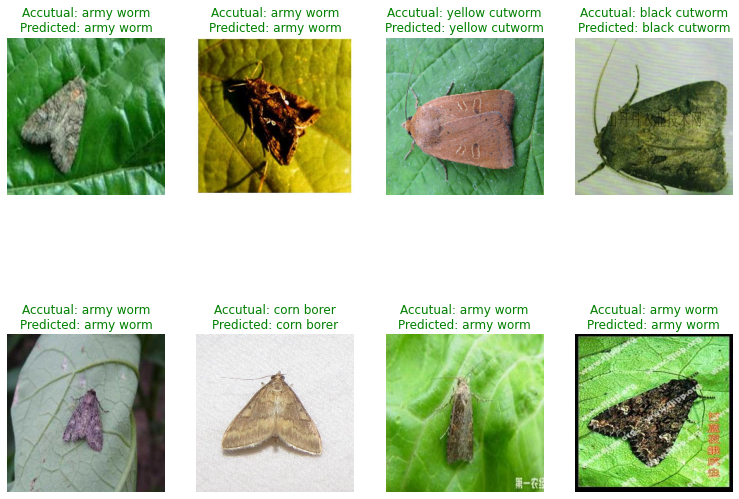

In [17]:
model = InsectModel(num_classes=4)
model.load_state_dict(torch.load("./vit_best.pth"))
images, labels = next(iter(val_data_loader))
preds = model(images).softmax(1).argmax(1)

fig, axs = plt.subplots(2,4,figsize=(13,10))
[ax.imshow(image.permute((1,2,0))) for image,ax in zip(images,axs.ravel())]
[ax.set_title("\n".join(wrap(f'Accutual: {classes.name[label.item()]} \n Predicted: {classes.name[pred.item()]}',30)),color = 'g' if label.item()==pred.item() else 'r') for label,pred,ax in zip(labels,preds,axs.ravel())]
[ax.set_axis_off() for ax in axs.ravel()]
plt.show()

#test
test_dataset = InsectDataset(image=test_df.values,
                            image_dir=TEST_DIR,
                            transform=train_transform())
test_data_loader = DataLoader(test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=2)